In [1]:
import numpy as np
from cobra.io import read_sbml_model

In [2]:
model = read_sbml_model('iML1515.xml.gz')

We want to look at the model. See if it has fluxes

In [3]:
solution = model.optimize()
solution.fluxes

CYTDK2     0.00000
XPPT       0.00000
HXPRT      0.00000
NDPK5      0.00000
SHK3Dr     0.33424
            ...   
MPTS       0.00000
MOCOS      0.00000
BMOGDS2    0.00000
FESD2s     0.00000
OCTNLL     0.00000
Name: fluxes, Length: 2712, dtype: float64

Checking what its objective is

In [4]:
model.summary()

We want to find the metabolite Purtescine in the model

In [5]:
for metabolite in model.metabolites.query('Putrescine', 'name'):
    print(metabolite.name)
    print(metabolite.id)

Putrescine
ptrc_p
Putrescine
ptrc_c
Putrescine
ptrc_e


In [6]:
model.metabolites.get_by_id('ptrc_c') # Putrescine

Metabolite identifier,ptrc_c
Name,Putrescine
Memory address,0x07f0fafe349e8
Formula,C4H14N2
Compartment,c
In 9 reaction(s),"ORNDC, SPMS, PTRCt2pp, PTRCTA, PTRCORNt7pp, AGMT, BIOMASS_Ec_iML1515_WT_75p37M, PTRCabcpp, GGPTRCS"


The reaction that produces purtescine from onithine is native to E.coli

In [7]:
model.reactions.ORNDC

Reaction identifier,ORNDC
Name,Ornithine Decarboxylase
Memory address,0x07f0fae9d5400
Stoichiometry,h_c + orn_c --> co2_c + ptrc_c H+ + Ornithine --> CO2 CO2 + Putrescine
GPR,b2965 or b0693
Lower bound,0.0
Upper bound,1000.0


We want to check the flux

In [8]:
with model:
    model.objective = model.reactions.ORNDC
    print(model.optimize().objective_value)  # We produce Purtescine

41.09128205128201


# Adding enzyme 2.6.1.13

In [9]:
from cobra import Reaction, Metabolite

To make E. Coli produce putrescine we need to add the reaction of the enzyme 2.6.1.13.
This is the same as we added in C. Glutamicum.

In [10]:
new_reaction_1 = Reaction('OAT')  # OAT -> (o)rnithine (a)mino(t)ransferase

In [11]:
for metabolite in model.metabolites.query('5-semialdehyde', 'name'):
    print(metabolite.name)
    print(metabolite.id)

N-Acetyl-L-glutamate 5-semialdehyde
acg5sa_c
N2-Succinyl-L-glutamate 5-semialdehyde
sucgsa_c
L-Glutamate 5-semialdehyde
glu5sa_c


In [12]:
model.metabolites.get_by_id('glu5sa_c') # L-glutamate 5-semialdehyde

Metabolite identifier,glu5sa_c
Name,L-Glutamate 5-semialdehyde
Memory address,0x07f0faff4eac8
Formula,C5H9NO3
Compartment,c
In 2 reaction(s),"G5SD, G5SADs"


We see that the two reactions L-glutamate 5-semialdehyde is part of correspond to the ones seen in the KEGG pathway map. We now need to find the other metabolites that play a role in conversion of L-glutamate 5-semialdehyde to ornithine.

In [13]:
for metabolite in model.metabolites.query('Ornithine', 'name'):
    print(metabolite.name)
    print(metabolite.id)

Ornithine
orn_e
Ornithine
orn_p
Ornithine
orn_c


In [14]:
model.metabolites.get_by_id('orn_c') # Ornithine

Metabolite identifier,orn_c
Name,Ornithine
Memory address,0x07f0fafe69470
Formula,C5H13N2O2
Compartment,c
In 6 reaction(s),"ORNDC, ORNabcpp, OCBT, ACODA, ARGORNt7pp, PTRCORNt7pp"


In [15]:
for metabolite in model.metabolites.query('Oxoglutarate', 'name'):
    print(metabolite.name)
    print(metabolite.id)

2-Oxoglutarate
akg_e
2-Oxoglutarate
akg_c
2-Oxoglutarate
akg_p


In [16]:
model.metabolites.get_by_id('akg_c') # 2-Oxoglutarate

Metabolite identifier,akg_c
Name,2-Oxoglutarate
Memory address,0x07f0fb01b0198
Formula,C5H4O5
Compartment,c
In 28 reaction(s),"ICDHyr, VALTA, ILETA, SOTA, OHPBAT, AHGDx, ACOTA, TDPAGTA, ABTA, AKGDH, TYRTA, SDPTA, UDPKAAT, PHETA1, GLUSy, SHGO, AKGt2rpp, GLUDy, ALATA_L, PTRCTA, PSERT, ARHGDx, LEUTAi, ASPTA, TAUDO, SEPHCHCS, ..."


In [17]:
for metabolite in model.metabolites.query('L-Glutamate', 'name'):
    print(metabolite.name)
    print(metabolite.id)

L-Glutamate 1-semialdehyde
glu1sa_c
L-Glutamate
glu__L_c
L-Glutamate 5-semialdehyde
glu5sa_c
L-Glutamate
glu__L_e
L-Glutamate
glu__L_p
L-Glutamate 5-phosphate
glu5p_c


In [18]:
model.metabolites.get_by_id('glu__L_c') # L-Glutamate

Metabolite identifier,glu__L_c
Name,L-Glutamate
Memory address,0x07f0faff4ba58
Formula,C5H8NO4
Compartment,c
In 51 reaction(s),"GLUR, GLU5K, VALTA, GMPS2, P5CD, ANS, OHPBAT, PRFGS, ACOTA, ABTA, GLUDC, SDPTA, GLUCYS, TYRTA, UDPKAAT, GLUSy, BIOMASS_Ec_iML1515_core_75p37M, GLUDy, ALATA_L, CTPS2, 4ABZGLUH, BIOMASS_Ec_iML1515_WT..."


Now we add the reaction to produce ornithine

In [19]:
new_reaction_1.add_metabolites({model.metabolites.get_by_id('glu5sa_c'): -1, # L-glutamate 5-semialdehyde
                              model.metabolites.get_by_id('glu__L_c'): -1, # L-glutamate 
                              model.metabolites.get_by_id('orn_c'): 1, # L-ornithine
                              model.metabolites.get_by_id('akg_c'): 1 # 2-oxoglutarate
                             })

In [20]:
print(new_reaction_1.build_reaction_string())

glu5sa_c + glu__L_c --> akg_c + orn_c


In [21]:
model.add_reactions([new_reaction_1])
model.reactions.OAT

Reaction identifier,OAT
Name,
Memory address,0x07f0faec0c198
Stoichiometry,glu5sa_c + glu__L_c --> akg_c + orn_c L-Glutamate 5-semialdehyde + L-Glutamate --> 2-Oxoglutarate + Ornithine
GPR,
Lower bound,0.0
Upper bound,1000.0


In [22]:
with model:
    model.objective = model.reactions.OAT
    print(model.optimize().objective_value)  # We produce L-ornithine

53.0233333333333


We want to see production rate of putrescine now after we have added a new path via glutamate

In [23]:
with model:
    model.objective = model.reactions.ORNDC
    print(model.optimize().objective_value)  # We produce Purtescine

45.78742857142852


We see that the production rate of putrescine increases from 41.09 to 45.79

# Adding enzyme 3.5.3.1

Uses L-arginine and H2O to make L-ornithine and Urea

In [24]:
for metabolite in model.metabolites.query('L-Arginine', 'name'):
    print(metabolite.name)
    print(metabolite.id)

L-Arginine
arg__L_c
L-Arginine
arg__L_e
L-Arginine
arg__L_p


In [25]:
for metabolite in model.metabolites.query('Urea', 'name'):
    print(metabolite.name)
    print(metabolite.id)

Urea CH4N2O
urea_c
Urea CH4N2O
urea_p
Urea CH4N2O
urea_e


In [26]:
for metabolite in model.metabolites.query('H2O', 'name'):
    print(metabolite.name)
    print(metabolite.id)

H2O H2O
h2o_p
H2O H2O
h2o_c
H2O H2O
h2o_e


In [27]:
new_reaction_2 = Reaction('AAH')  # AAH -> L-arginine amidinohydrolase

In [28]:
new_reaction_2.add_metabolites({model.metabolites.get_by_id('arg__L_c'): -1, # L-arginine
                              model.metabolites.get_by_id('h2o_c'): -1, # H2O 
                              model.metabolites.get_by_id('orn_c'): 1, # L-ornithine
                              model.metabolites.get_by_id('urea_c'): 1 # Urea
                             })

In [29]:
print(new_reaction_2.build_reaction_string())

arg__L_c + h2o_c --> orn_c + urea_c


In [30]:
model.add_reactions([new_reaction_2])
model.reactions.AAH

Reaction identifier,AAH
Name,
Memory address,0x07f0faec6e710
Stoichiometry,arg__L_c + h2o_c --> orn_c + urea_c L-Arginine + H2O H2O --> Ornithine + Urea CH4N2O
GPR,
Lower bound,0.0
Upper bound,1000.0


In [31]:
with model:
    model.objective = model.reactions.ORNDC
    print(model.optimize().objective_value)  # We produce Purtescine

45.78742857142852


# Finding theoretical yield

We want to add a reaction that excretes putrescine

In [32]:
model.add_boundary(model.metabolites.ptrc_c, type='demand')

Reaction identifier,DM_ptrc_c
Name,Putrescine demand
Memory address,0x07f0faec65da0
Stoichiometry,ptrc_c --> Putrescine -->
GPR,
Lower bound,0
Upper bound,1000.0


We want to look at the medium composition

In [33]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

We find the maximal theoretical yield of putrescine both before and after adding our reaction OAT. 

In [34]:
medium = model.medium
with model:
    model.reactions.OAT.bounds = 0,0
    model.medium = medium
    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 9.653333333333332
Theoretical max. yield [mmol-put / mmol-glc]: 0.9653333333333333


In [35]:
medium = model.medium
with model:
    model.medium = medium
    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 10.01910447761193
Theoretical max. yield [mmol-put / mmol-glc]: 1.0019104477611929


We see an increase in theoretical yield.

# Testing

In [36]:
for reaction in model.reactions.query('succinyl', 'name'):
    print(reaction.name)
    print(reaction.id)

O-succinylbenzoate-CoA synthase
SUCBZS
Succinyl-diaminopimelate desuccinylase
SDPDS
Arginine succinyltransferase
AST
Succinylglutamate desuccinylase
SGDS
Homoserine O-succinyltransferase
HSST
O-succinylhomoserine lyase (L-cysteine)
SHSL1
Tetrahydrodipicolinate succinylase
THDPS
O-succinylbenzoate-CoA ligase
SUCBZL
2-succinyl-6-hydroxy-2,4-cyclohexadiene 1-carboxylate synthase
SHCHCS3
2-succinyl-5-enolpyruvyl-6-hydroxy-3-cyclohexene-1-carboxylate synthase
SEPHCHCS


In [37]:
model.reactions.AST

Reaction identifier,AST
Name,Arginine succinyltransferase
Memory address,0x07f0faf4b8908
Stoichiometry,arg__L_c + succoa_c --> coa_c + h_c + sucarg_c L-Arginine + Succinyl-CoA --> Coenzyme A + H+ + N2-Succinyl-L-arginine
GPR,b1747
Lower bound,0.0
Upper bound,1000.0


In [38]:
medium = model.medium
with model:
    model.medium = medium
    model.reactions.AST.bounds = 0,0
    model.reactions.AAH.bounds = 0,0
    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 10.01910447761193
Theoretical max. yield [mmol-put / mmol-glc]: 1.0019104477611929


In [39]:
for reaction in model.reactions.query('carboxylase', 'name'):
    print(reaction.name)
    print(reaction.id)

Orotidine-5'-phosphate decarboxylase
OMPDC
Uroporphyrinogen decarboxylase (uroporphyrinogen III)
UPPDC1
Phosphoribosylaminoimidazole carboxylase (mutase rxn)
AIRC3
Phosphopantothenoylcysteine decarboxylase
PPCDC
Acetyl-CoA carboxylase
ACCOAC
Adenosylmethionine decarboxylase
ADMDC
Arginine decarboxylase
ARGDC
Oxaloacetate decarboxylase
OAADC
Malonyl-ACP decarboxylase
MACPD
Phosphoenolpyruvate carboxylase
PPC
Octaprenyl-hydroxybenzoate decarboxylase
OPHBDC
3-keto-L-gulonate 6-phosphate decarboxylase
KG6PDC
Aspartate 1-decarboxylase
ASP1DC
Diaminopimelate decarboxylase
DAPDC
Phosphoribosylaminoimidazole carboxylase
AIRC2
Glutamate Decarboxylase
GLUDC
Arginine decarboxylase
ARGDCpp
Lysine decarboxylase
LYSDC
UDP-glucuronate C-4'' decarboxylase
UDPGDC
Methylmalonyl-CoA decarboxylase
MMCD
Ornithine Decarboxylase
ORNDC
Phosphatidylserine decarboxylase (n-C16:0)
PSD160
Phosphatidylserine decarboxylase (n-C16:1)
PSD161
Phosphatidylserine decarboxylase (n-C18:0)
PSD180
Phosphatidylserine decarbo

In [40]:
model.reactions.ARGDC

Reaction identifier,ARGDC
Name,Arginine decarboxylase
Memory address,0x07f0faf644630
Stoichiometry,arg__L_c + h_c --> agm_c + co2_c L-Arginine + H+ --> Agmatine + CO2 CO2
GPR,b4117
Lower bound,0.0
Upper bound,1000.0


In [41]:
medium = model.medium
with model:
    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 10.01910447761193
Theoretical max. yield [mmol-put / mmol-glc]: 1.0019104477611929


In [42]:
model.metabolites.ptrc_c

Metabolite identifier,ptrc_c
Name,Putrescine
Memory address,0x07f0fafe349e8
Formula,C4H14N2
Compartment,c
In 10 reaction(s),"ORNDC, SPMS, PTRCt2pp, PTRCTA, PTRCORNt7pp, AGMT, BIOMASS_Ec_iML1515_WT_75p37M, PTRCabcpp, DM_ptrc_c, GGPTRCS"


In [43]:
medium = model.medium
with model:
    model.medium = medium
    #model.reactions.AGMT.bounds = 0,0
    model.reactions.AAH.bounds = 0,0
    model.reactions.OAT.bounds = 0,0

    model.reactions.ORNDC.bounds = 0,0

    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 8.40774193548387
Theoretical max. yield [mmol-put / mmol-glc]: 0.840774193548387


In [44]:
model.reactions.ORNDC

Reaction identifier,ORNDC
Name,Ornithine Decarboxylase
Memory address,0x07f0fae9d5400
Stoichiometry,h_c + orn_c --> co2_c + ptrc_c H+ + Ornithine --> CO2 CO2 + Putrescine
GPR,b2965 or b0693
Lower bound,0.0
Upper bound,1000.0


We try and see if removing spermidine synthesis from putrescine makes a difference

In [45]:
for metabolite in model.metabolites.query('Spermidine', 'name'):
    print(metabolite.name)
    print(metabolite.id)

Spermidine
spmd_e
Spermidine
spmd_c
Spermidine
spmd_p


In [46]:
model.metabolites.ptrc_c

Metabolite identifier,ptrc_c
Name,Putrescine
Memory address,0x07f0fafe349e8
Formula,C4H14N2
Compartment,c
In 10 reaction(s),"ORNDC, SPMS, PTRCt2pp, PTRCTA, PTRCORNt7pp, AGMT, BIOMASS_Ec_iML1515_WT_75p37M, PTRCabcpp, DM_ptrc_c, GGPTRCS"


In [47]:
#model.metabolites.spmd_c

In [48]:
#model.reactions.SPMS

In [49]:
#for metabolite in model.metabolites.query('butanal', 'name'):
    print(metabolite.name)
    print(metabolite.id)

Spermidine
spmd_p


In [50]:
#model.metabolites.get_by_id('4abutn_c')

In [51]:
#model.reactions.PTRCTA

In [52]:
for metabolite in model.metabolites.query('N-acetyl', 'name'):
    print(metabolite.name)
    print(metabolite.id)

N-acetylmuramate 6-phosphate
acmum6p_c
UDP-N-acetylmuramate
uamr_c
Undecaprenyl-diphospho N-acetylglucosamine-N-acetylmannosaminuronate-N-acetamido-4,6-dideoxy-D-galactose
unagamuf_c
Poly-?-1,6-N-acetyl-D-glucosamine
puacgam_p
Undecaprenyl-diphospho-N-acetylglucosamine-N-acetylmannosaminuronate
unagamu_c
UDP-N-acetylmuramoyl-L-alanyl-D-gamma-glutamyl-meso-2,6-diaminopimelate-D-alanine
um4p_c
UDP-3-O-(3-hydroxytetradecanoyl)-N-acetylglucosamine
u3aga_c
UDP-N-acetyl-D-mannosamine
uacmam_c
UDP-N-acetylmuramoyl-L-alanyl-D-gamma-glutamyl-meso-2,6-diaminopimelate
ugmd_c
Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L-ala-D-glu-meso-2,6-diaminopimeloyl-D-ala-D-ala
uaagmda_c
Poly-?-1,6-N-acetyl-D-glucosamine
puacgam_c
UDP-N-acetylmuramoyl-L-alanyl-D-glutamate
uamag_c
Rhamanosyl-N-acetylglucosamyl-undecaprenyl diphosphate
ragund_c
Undecaprenyl-diphospho-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-2,6-diaminopimeloyl-D-alanyl-D-alanine
uagmda_c
Glucosyl-O-acetyl-rhamanosyl-N-acetyl

In [53]:
model.metabolites.ggptrc_c

Metabolite identifier,ggptrc_c
Name,Gamma-glutamyl-putrescine
Memory address,0x07f0fb0058668
Formula,C9H20O3N3
Compartment,c
In 2 reaction(s),"GGPTRCO, GGPTRCS"


In [54]:
model.reactions.PTRCabcpp

Reaction identifier,PTRCabcpp
Name,Putrescine transport via ABC system (periplasm)
Memory address,0x07f0faedda940
Stoichiometry,atp_c + h2o_c + ptrc_p --> adp_c + h_c + pi_c + ptrc_c ATP C10H12N5O13P3 + H2O H2O + Putrescine --> ADP C10H12N5O10P2 + H+ + Phosphate + Putrescine
GPR,( b0854 and b0855 and b0857 and b0856 ) or ( b1440 and b1442 and b1441 and b1443 ) or ( b1125 and...
Lower bound,0.0
Upper bound,1000.0


In [55]:
medium = model.medium
with model:
    model.medium = medium
    model.reactions.GGPTRCS.bounds = 0,0
    model.reactions.PTRCTA.bounds = 0,0
    model.reactions.SPMS.bounds = 0,0
    model.objective = model.reactions.DM_ptrc_c
    put_production = model.optimize().objective_value
    print("Max. putriscine production [mmol gDW^-1 h^-1]:", put_production)
    print("Theoretical max. yield [mmol-put / mmol-glc]:", put_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. putriscine production [mmol gDW^-1 h^-1]: 10.019104477611934
Theoretical max. yield [mmol-put / mmol-glc]: 1.0019104477611935


## Phenotypic phase plane analysis

In [56]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope

In [57]:
ppp_BIOMASS = production_envelope(model,
                    reactions=[model.reactions.EX_glc__D_e],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [58]:
ppp_BIOMASS

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_glc__D_e
0,EX_glc__D_e,0.0,0.0,NaN,0.877974,11.630450,NaN,-10.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831794,11.612022,NaN,-9.489048
2,EX_glc__D_e,0.0,0.0,NaN,0.785614,11.591498,NaN,-8.978096
3,EX_glc__D_e,0.0,0.0,NaN,0.739433,11.568496,NaN,-8.467144
4,EX_glc__D_e,0.0,0.0,NaN,0.693253,11.542540,NaN,-7.956193
5,EX_glc__D_e,0.0,0.0,NaN,0.647073,11.513021,NaN,-7.445241
6,EX_glc__D_e,0.0,0.0,NaN,0.600893,11.479152,NaN,-6.934289
7,EX_glc__D_e,0.0,0.0,NaN,0.554712,11.439894,NaN,-6.423337
8,EX_glc__D_e,0.0,0.0,NaN,0.508532,11.393852,NaN,-5.912385
9,EX_glc__D_e,0.0,0.0,NaN,0.462352,11.339098,NaN,-5.401433


<AxesSubplot:xlabel='EX_glc__D_e'>

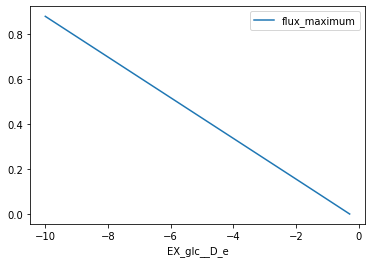

In [60]:
ppp_BIOMASS.plot(x='EX_glc__D_e', y='flux_maximum')